In [1]:
import yfinance as yf
import pandas as pd

#Download S&P 500 data
sp500 = yf.download('^GSPC', start='2024-01-01', end='2025-05-27')
sp500_df = sp500[['Close']].copy()
sp500_df.reset_index(inplace=True)  #Moves date from index to column
sp500_df.columns = ['Date', 'Closing_Price'] 
sp500_df.set_index('Date', inplace=True)# Convert date again to index
sp500_df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Closing_Price
Date,
2024-01-02,4742.830078
2024-01-03,4704.810059
2024-01-04,4688.680176
2024-01-05,4697.240234
2024-01-08,4763.540039
...,...
2025-05-19,5963.600098
2025-05-20,5940.459961
2025-05-21,5844.609863


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
sp500_df.shape

(349, 1)

In [36]:
sp500_df.describe() 

,Closing_Price
count,350.000000
mean,5522.168828
std,375.264874
min,4688.680176
25%,5212.137695
50%,5565.800049
75%,5842.840088
max,6144.149902


In [32]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2024-01-02 to 2025-05-23
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Closing_Price  350 non-null    float64
 1   Year           350 non-null    int32  
 2   Month          350 non-null    int32  
dtypes: float64(1), int32(2)
memory usage: 8.2 KB


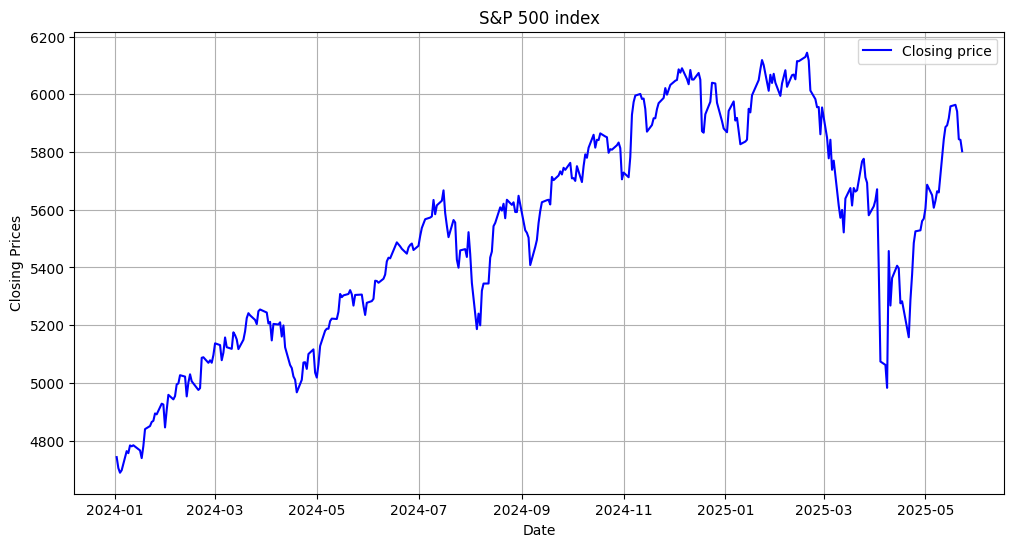

In [ ]:
def plot_timeseries(df:pd.DataFrame):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df["Closing_Price"], label="Closing price", color="blue")
    plt.title("S&P 500 index")
    plt.xlabel("Date")
    plt.ylabel("Closing Prices")
    plt.grid(True)
    plt.legend()
    plt.show()
plot_timeseries(sp500_df)

# The raw graph shows clear trend as well as some signs for seasonal patterns

Skewness: -0.23272738344937127
Kurtosis: -0.9736056290423591


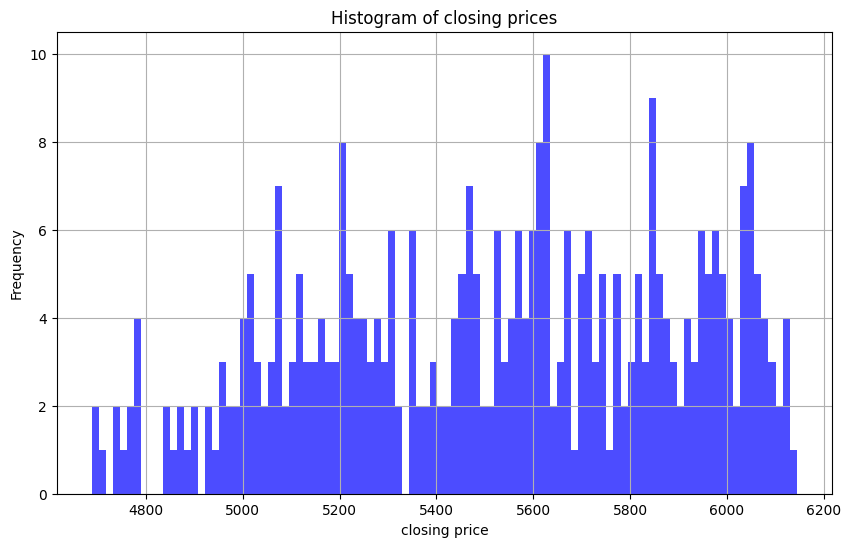

In [ ]:
from scipy.stats import skew, kurtosis

skewness = skew(sp500_df["Closing_Price"])
kurt = kurtosis(sp500_df["Closing_Price"])
print("Skewness:", skewness) 
print("Kurtosis:", kurt)
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sp500_df["Closing_Price"], bins=100, color='blue', alpha=0.7)
plt.title("Histogram of closing prices")
plt.xlabel("closing price")
plt.ylabel("Frequency")        
plt.grid(True)         
plt.show()    


#the data distribution is thin-tailed(platykurtic), which in turn means there are fewer outliers compared to a normal distribution.
#thinner tails imply  that the PDF drops off more sharply as data move away from the mean, so the probability of extreme values falls off faster than in leptokurtic or mesokurtic distributions


Now we move on to perform Seasonal decomposition For this an approprite period needs to be selected aka Seasonal Window.

This controls the smoothness and flexibility of the estimated seasonal component
A smaller window allows the seasonal component to adapt quickly to changes, while a larger window forces it to be smoother and less responsive to short-term  fluctuations,

Too small  window: The seasonal/trend components may capture noise or short-term fluctuations, leading to overfitting.
If we underestimate (choose too small) the window size, we risk overfitting noise as seasonality. 

Too large window: The components may miss genuine changes and underfit, failing to capture actual seasonality or trend shifts.


Overestimating the window size in seasonal decomposition leads to a loss of detail in the seasonal component, making it too smooth and potentially causing the model to miss or understate real, shorter-term seasonal patterns. The trend may then incorrectly absorb these patterns, and the decomposition will not accurately reflect the true structure of your data

Selecting appropriate window: 


Analyze the data for dominant repeating patterns using autocorrelation plots, periodograms, or Fourier transforms. Peaks in these analyses suggest likely seasonal periods, which can inform your window size.

Subsequence-based methods: These examine local patterns and compare them to global properties to select a window size that best captures repetitive local behavior.

(source: https://project.inria.fr/aaltd22/files/2022/08/AALTD22_paper_3876.pdfhttps://project.inria.fr/aaltd22/files/2022/08/AALTD22_paper_3876.pdf)


Plot your time series and look for repeating patterns or cycles.

Use ACF plots to identify lags with high correlation, which often correspond to the period of seasonality.

Experiment with different window sizes and inspect the resulting seasonal component. Choose a size that captures meaningful, smooth patterns without overfitting noise.



In [ ]:
# lets begin with applying fourier transform , the Peaks in the frequency spectrum indicate dominant periodicities, which can be used to set the window size.
# first lets detrend the data to get more clarity since trend can mask periodic signals
test_sp500=sp500_df.copy()
test_sp500["Closing_Price"]=test_sp500["Closing_Price"].diff().dropna()
test_sp500=test_sp500.dropna()


In [11]:

sp500_df[sp500_df.isnull().any(axis=1)]

,Closing_Price
Date,


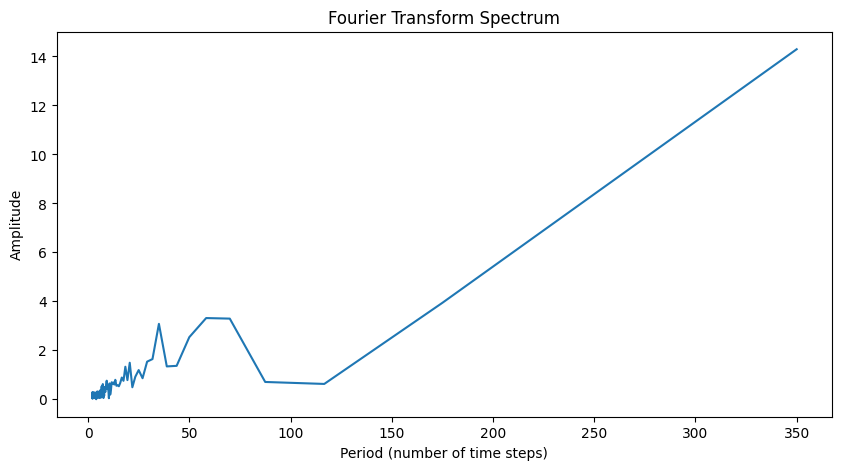

In [ ]:
#The Fourier Transform decomposes your time series into a sum of sine and cosine waves of different frequencies. 
# The result is a spectrum showing which frequencies (periodicities) are most prominent.

import numpy as np
import matplotlib.pyplot as plt


data =test_sp500["Closing_Price"].values

# Compute the Fourier Transform
fft_vals = np.fft.fft(data)
fft_freq = np.fft.fftfreq(len(data))

# Only keep the positive frequencies
pos_mask = fft_freq > 0
fft_freq = fft_freq[pos_mask]
fft_power = np.abs(fft_vals[pos_mask])

# Plot the spectrum
plt.figure(figsize=(10, 5))
plt.plot(1/fft_freq, fft_power)
plt.xlabel('Period (number of time steps)')
plt.ylabel('Amplitude')
plt.title('Fourier Transform Spectrum')
plt.show() 

#The high amplitudes at low frequencies (first 50 points) mean your data has strong long-term trends or cycles. 
#The flatness at higher frequencies means there is little to no regular short-term seasonality or repeating patterns in your data after detrending.





C:\Users\injil\AppData\Local\Temp\ipykernel_13816\769327080.py:8: RuntimeWarning: divide by zero encountered in divide
  periods = np.where(freqs > 0, 1 / freqs, 0)


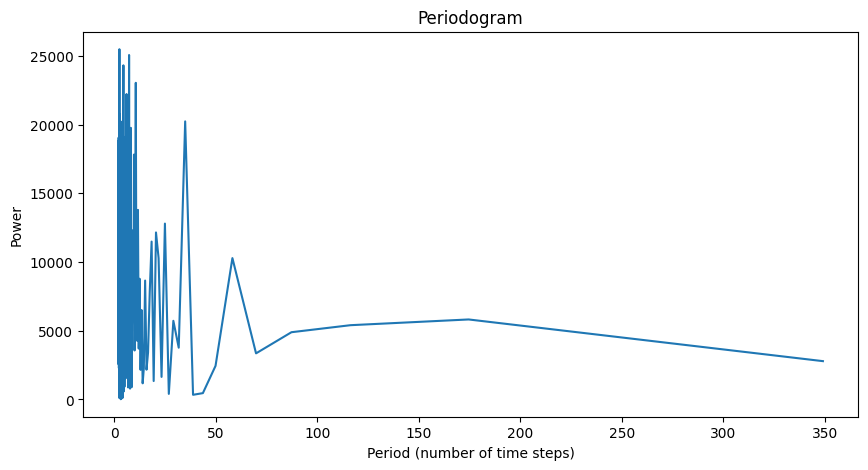

In [76]:
from scipy.signal import periodogram

# Suppose 'data' is your time series
fs = 1  # Sampling frequency (1 for regular time steps, adjust if needed)
freqs, power = periodogram(data, fs=fs)

# Convert frequency to period (avoid division by zero)
periods = np.where(freqs > 0, 1 / freqs, 0)

plt.figure(figsize=(10, 5))
plt.plot(periods[freqs > 0], power[freqs > 0])
plt.xlabel('Period (number of time steps)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.show()


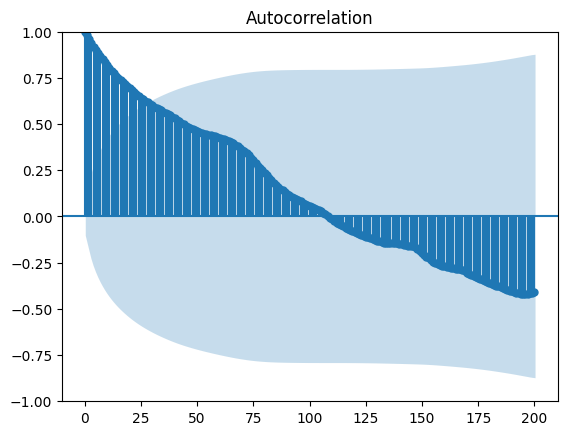

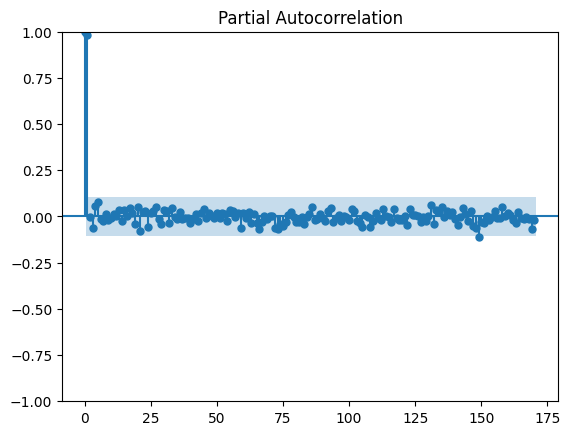

In [ ]:

#Lets check the ACF and PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = plot_acf(sp500_df["Closing_Price"].dropna(), lags=200)
plot_pacf(sp500_df["Closing_Price"].dropna(), lags=170)
plt.show()








#Conclusion : 
We get a A gradually decaying ACF (where correlations slowly diminish as lags increase)  this typically indicates a trend in the data, not however trends can  dominate autocorrelation, masking weaker seasonal patterns.
IN the PACF plot for lags upto 170 the graph shows almost no statistically significant correlation.

#How to Confirm Seasonality (or Lack Thereof)
1: Detrend the Data
Remove the trend using differencing or detrending methods. After detrending, recalculate the ACF:
If peaks emerge: The trend was masking seasonality.
If ACF still decays: The data may have no seasonality.


2: Visual Inspection
Plot the time series and look for repeating patterns (e.g., monthly spikes, quarterly dips). If no visual seasonality exists, the ACF’s lack of peaks aligns with this.


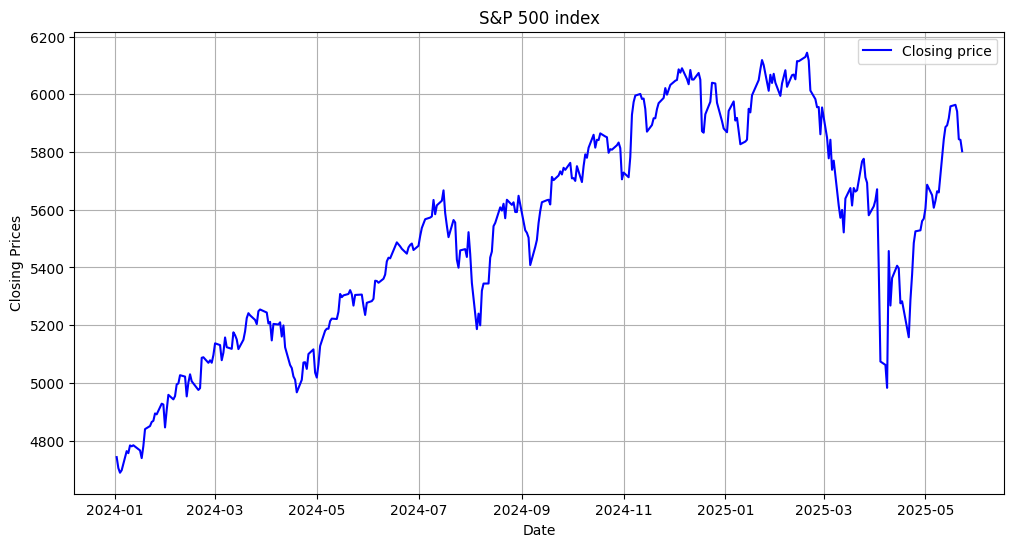

In [9]:
test_sp500=sp500_df.copy()

test_sp500["Closing_Price"]=test_sp500["Closing_Price"].diff().dropna()


plot_timeseries(test_sp500)
# chekc acf, pacf again

THe above methods are not very clearly able to estimate the window size 
Lets Experiment with different window sizes and inspect the resulting seasonal component. Choose a size that captures meaningful, smooth patterns without overfitting noise.

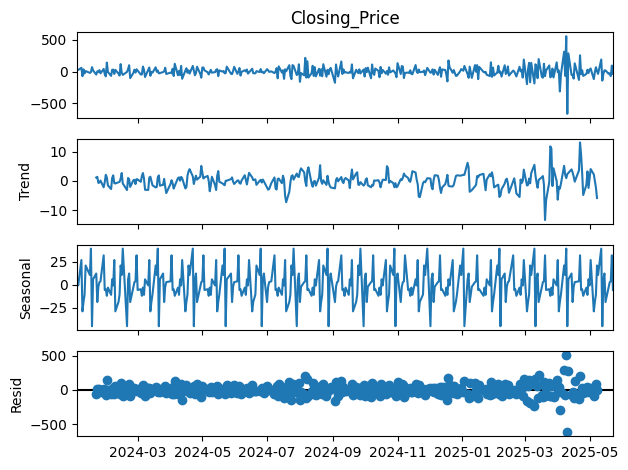

'Multiplicative Model: Straight Line of Residuals\n\nIn a multiplicative model, residuals should also ideally be centered around a baseline (often 1 if you’re looking at ratios, or 0 after log transformation).\n\nIf you get a straight line (e.g., all residuals are zero or a constant value), this could mean:\n\nThe model has perfectly explained all the variation in the data (rare in real-world scenarios).\n\nThere may be an issue with the decomposition process, such as overfitting, data preprocessing errors, or inappropriate model choice.\n\nAlternatively, if you see a flat line at zero after log transformation, it might indicate that the multiplicative \nmodel is a perfect fit for your data structure, but this is uncommon in practice'

In [23]:

# Decompose the time series data


"""The additive decomposition is the most appropriate if the magnitude of the seasonal fluctuations, 
or the variation around the trend-cycle, does not vary with the level of the time series. 
When the variation in the seasonal pattern, or the variation around the trend-cycle, appears to be 
proportional to the level of the time series, then a multiplicative decomposition is more appropriate. 
Multiplicative decompositions are common with economic time series."""


"""An alternative to using a multiplicative decomposition is to first transform the data until the variation 
in the series appears to be stable over time, then use an additive decomposition. 
When a log transformation has been used, this is equivalent to using a multiplicative decomposition on the 
original data because
yt=St × Tt × Rt is equivalent to logyt = logSt + logt + logRt
"""


'''When we decompose a time series into components, we usually combine the trend and cycle into
a single trend-cycle component (often just called the trend for simplicity). 
Thus we can think of a time series as comprising three components: a trend-cycle component, 
a seasonal component, and a remainder(residual) component ''' 
"""  
The residual is just what’s left over after the trend and seasonality have been removed from the target series.
  
The residual can be formed by either subtracting out or dividing out the calculated trend and seasonality, 
depending on whether the target is assessed to have additive or multiplicative trend and seasonality respectively.

 
 """

sp500_df=sp500_df.dropna()
result = seasonal_decompose(sp500_df["Closing_Price"], model='additive', period=22) 
result.plot()

plt.show() 

# WE take a window size of 88 ~ 4 months
# The residuals should be randomly distributed with no obvious patterns and no unusual values. 
"""In an additive model, residuals are expected to be centered around zero if the model fits well.
However, if you see a pattern in the residuals (such as a trend, seasonality, or clustering), 
this suggests the model has not fully captured all the structure in your data. The remaining pattern indicates 
that some systematic variation (trend or seasonality) is still present in the residuals, meaning the additive 
model may not be appropriate or sufficient for your data"""



"""Multiplicative Model: Straight Line of Residuals

In a multiplicative model, residuals should also ideally be centered around a baseline (often 1 if you’re looking at ratios, or 0 after log transformation).

If you get a straight line (e.g., all residuals are zero or a constant value), this could mean:

The model has perfectly explained all the variation in the data (rare in real-world scenarios).

There may be an issue with the decomposition process, such as overfitting, data preprocessing errors, or inappropriate model choice.

Alternatively, if you see a flat line at zero after log transformation, it might indicate that the multiplicative 
model is a perfect fit for your data structure, but this is uncommon in practice"""



In [ ]:
from statsmodels.tsa.seasonal import STL
stl = STL(sp500_df["Closing_Price"], period=88, robust=True)
res = stl.fit()
res.plot()


In [ ]:
plt.plot(res.resid)
plt.title('Residual Component')


In [ ]:



# Decompose 
result = seasonal_decompose(sp500_df["Closing_Price"], model='additive', period=88)
residual = result.resid

# Plot residuals
residual.plot(figsize=(10, 6))
plt.title("residuals After Decomposition")
plt.show()


# Detect large residuals
outliers = residual[np.abs(residual) > 3 * residual.std()]
print(outliers)



"""Constant Variance (Homoscedasticity):
Residuals should have constant variance (meaning their spread should be roughly the same across time). If the variance changes over time, 
it could indicate heteroscedasticity (inconsistent variance), which the model should address.

Why Important: Constant variance ensures reliable predictions across time.

Homoscedasticity: Residuals are randomly scattered with similar spread throughout.

Heteroscedasticity: Residuals show a pattern where their spread changes, such as getting wider or narrower as fitted values increase"""


SyntaxError: invalid syntax (2083090163.py, line 18)

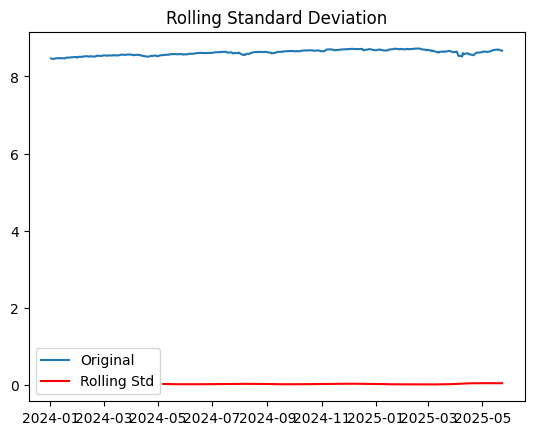

In [ ]:
# checking for variance

rolling_std = sp500_df["Closing_Price"].rolling(window=88).std()
plt.plot(sp500_df["Closing_Price"], label='Original')
plt.plot(rolling_std, label='Rolling Std', color='red')
plt.legend()
plt.title("Rolling Standard Deviation")
plt.show() 

#For a stationary series, the rolling standard deviation should be roughly constant over time.

#here the fluctuations are less but it might be because there is a trend in the data i.e mean is not constant .
# the true realtionship can be revealed if we remove the trend somehow



#When a time series has a non-constant mean (trend), the rolling standard deviation calculated directly on the raw data may not 
# accurately reflect changes in volatility or variance. The trend can artificially stabilize or suppress the fluctuations in the standard deviation,
#  making it seem more constant than it truly is.

In [ ]:
#If your rolling standard deviation is flat despite a trending mean, detrending the data will help unveil any hidden changes in variance, allowing the rolling standard deviation to reflect the true variability in your time series.
sp500_df["Closing_Price"]=sp500_df["Closing_Price"].diff().dropna()


C:\Users\injil\AppData\Local\Temp\ipykernel_13816\3319159570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df["Closing_Price"]=sp500_df["Closing_Price"].diff().dropna()


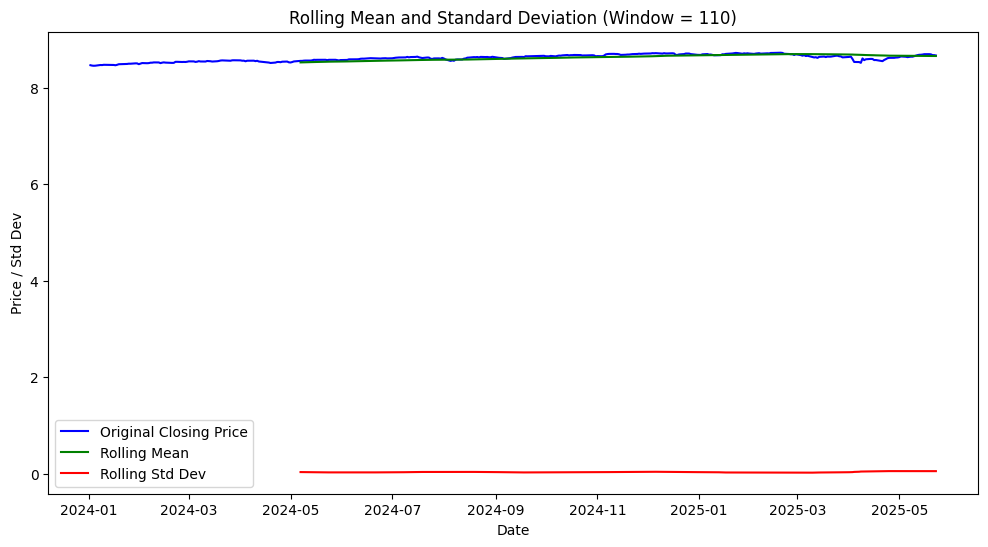

In [26]:
import matplotlib.pyplot as plt

window_size = 88

#Calculate rolling mean and rolling std deviation
rolling_mean = sp500_df["Closing_Price"].rolling(window=window_size).mean()
rolling_std = sp500_df["Closing_Price"].rolling(window=window_size).std()

# Plot original series, rolling mean, and rolling std
plt.figure(figsize=(12, 6))
plt.plot(sp500_df["Closing_Price"], label='Original Closing Price', color='blue')
plt.plot(rolling_mean, label='Rolling Mean', color='green')
plt.plot(rolling_std, label='Rolling Std Dev', color='red')
plt.legend()
plt.title("Rolling Mean and Standard Deviation (Window = 110)")
plt.xlabel("Date")
plt.ylabel("Price / Std Dev")   
plt.show()


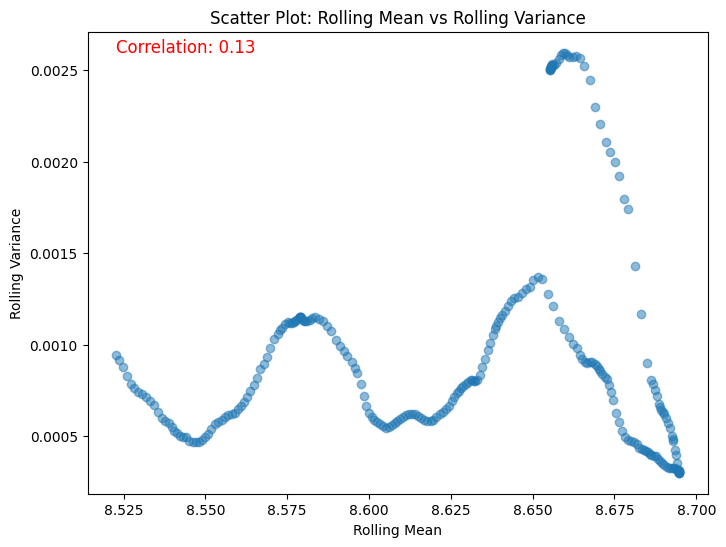

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate rolling mean and variance
rolling_mean = sp500_df["Closing_Price"].rolling(window=88).mean()
rolling_var = sp500_df["Closing_Price"].rolling(window=88).var()

# Drop NaN values resulting from rolling calculations
rolling_mean = rolling_mean.dropna()
rolling_var = rolling_var.dropna()

# Scatter plot
plt.figure(figsize=(8,6))
plt.scatter(rolling_mean, rolling_var, alpha=0.5)
plt.xlabel('Rolling Mean')
plt.ylabel('Rolling Variance')
plt.title('Scatter Plot: Rolling Mean vs Rolling Variance')

# Calculate correlation coefficient
corr = np.corrcoef(rolling_mean, rolling_var)[0,1]

# Display correlation coefficient on the plot
plt.text(min(rolling_mean), max(rolling_var), f'Correlation: {corr:.2f}', fontsize=12, color='red')
plt.show()


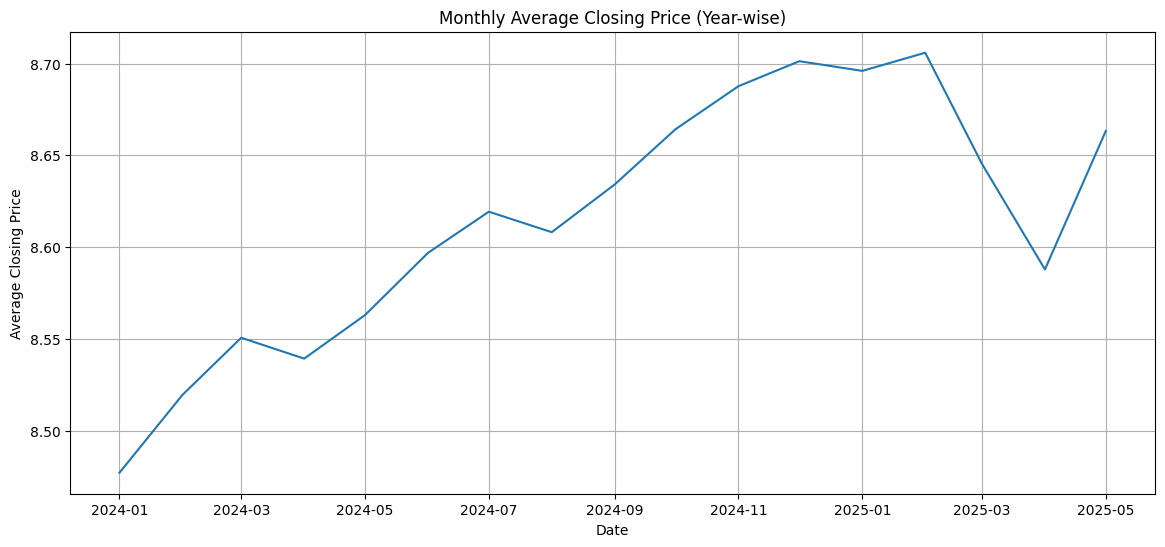

In [27]:
#Extract both year and month from the datetime index
sp500_df["Year"] = sp500_df.index.year
sp500_df["Month"] = sp500_df.index.month

#Group by Year and Month
monthly_mean = sp500_df.groupby(["Year", "Month"])["Closing_Price"].mean()

# Convert to a DataFrame for easier plotting
monthly_mean = monthly_mean.reset_index()

# Optional: create a 'Year-Month' column for plotting
monthly_mean["YearMonth"] = pd.to_datetime(monthly_mean["Year"].astype(str) + "-" + monthly_mean["Month"].astype(str))

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 6))
plt.plot(monthly_mean["YearMonth"], monthly_mean["Closing_Price"])
plt.title("Monthly Average Closing Price (Year-wise)")
plt.xlabel("Date")
plt.ylabel("Average Closing Price")
plt.grid(True)
plt.show()


LOG TRANSFORM

In [23]:
sp500_df["Closing_Price"] = np.log(sp500_df["Closing_Price"])

BOX COX TRANSFORM

In [ ]:
import numpy as np
from scipy.stats import boxcox


# Apply Box-Cox transformation
sp500_df["Closing_Price"], lambda_val = boxcox(sp500_df["Closing_Price"])


ValueError: Data must be positive.

In [23]:

from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(sp500_df["Closing_Price"] )
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])
print("Critical Values:", result_adfuller[4])# this prints the critical values as key_value pair 
if result_adfuller[0]>(result_adfuller[4])['5%']:
    print("The time seriess is Non_Stationary")
else:
    print("THe result is stationary")

ADF Statistic: -9.791004705105387
p-value: 6.353868779330703e-17
Critical Values: {'1%': -3.4583663275730476, '5%': -2.8738660999177132, '10%': -2.5733390785693766}
THe result is stationary


In [ ]:
ts=sp500_df["Closing_Price"].diff().dropna()

In [24]:
import pymannkendall as mk
# Perform Mann-Kendall test

result = mk.original_test(sp500_df["Closing_Price"].dropna())
print(result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.5809304531498654, z=-0.5520261267058634, Tau=-0.024014626771210575, s=-683.0, var_s=1526333.6666666667, slope=-6.81123933268428e-06, intercept=0.000635521615143103)


In [16]:
sp500_df = sp500_df.copy()
sp500_df["Closing_Price"] = sp500_df["Closing_Price"] - sp500_df["Closing_Price"].shift(110)

In [17]:
sp500_df=sp500_df.dropna()

In [25]:
from scipy.stats import friedmanchisquare

# Drop NaNs (e.g., from differencing)
values = sp500_df["Closing_Price"].dropna().values

# Ensure the length is divisible by 12 (e.g., complete years)
length = len(values) - (len(values) % 12)
values = values[:length]

# Reshape to (n_years, 12 months)
data = values.reshape(-1, 12)

# Apply Friedman test across columns (months)
stat, p = friedmanchisquare(*data.T)
print(f"Friedman p-value: {p:.6f}")  

# If p-value < 0.05, reject the null hypothesis of equal distributions across months
if p < 0.05:
    print("There are significant differences in the distributions of electric production across months, Means Seasonality exists.")   
else:
    print("No significant differences in the distributions of electric production across months, Seasonality does not exist.")

Friedman p-value: 0.092611
No significant differences in the distributions of electric production across months, Seasonality does not exist.


In [28]:
"""
ARCH Test (Autoregressive Conditional Heteroskedasticity Test)

The ARCH test is a statistical test used to detect the presence of autoregressive conditional heteroskedasticity (ARCH) effects in a time series. 
ARCH effects indicate that the variance of the current error term or innovation is related to the variances of previous time periods' error terms, 
which is common in financial and economic time series.

How it works:
- The test fits a regression model to the squared residuals of a time series.
- It checks whether past squared residuals can explain the current squared residual.
- If the test statistic is significant (low p-value), it suggests the presence of ARCH effects (time-varying volatility).

Use case:
- The ARCH test is commonly used before fitting GARCH or other volatility models to determine if modeling conditional heteroskedasticity is necessary.

Hypotheses:
- Null Hypothesis (H0): No ARCH effects (homoskedasticity; constant variance).
- Alternative Hypothesis (H1): Presence of ARCH effects (heteroskedasticity; time-varying variance).
Interpretation:
- A p-value less than the chosen significance level (e.g., 0.05) indicates rejection of the null hypothesis, suggesting the presence of ARCH effects.
"""


# ARCH test
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(sp500_df["Closing_Price"].dropna())
if arch_test[1]<0.05: 
    print("Arch effects present")
else:
    print("Arch effects not present")

print("P-value: ", arch_test[1])

Arch effects present
P-value:  8.130288007911138e-05


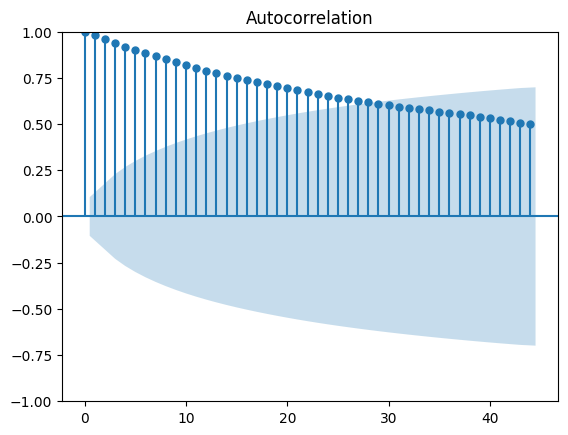

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = plot_acf(sp500_df["Closing_Price"].dropna(), lags=44)

plt.show()


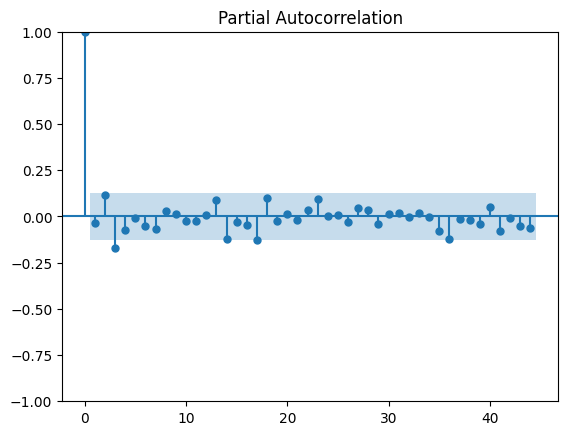

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

result = plot_pacf(sp500_df["Closing_Price"].dropna(), lags=44)

plt.show()

In [29]:
""" 
Coefficients:

mu: This is the constant term in the mean equation (if you included one). It represents the average value of the series.
omega: This is the constant term in the variance equation. It's the long-run average variance. It must be positive.
alpha[1]: This is the coefficient on the lagged squared residual (the ARCH term). It indicates how much the previous period's shock affects current volatility. It should be positive and less than 1.
beta[1]: This is the coefficient on the lagged conditional variance (the GARCH term). It indicates how much the previous period's volatility affects current volatility. It should be positive and less than 1.
alpha[1] + beta[1]: The sum of these coefficients is crucial. If it's close to 1, it suggests that volatility is very persistent (it takes a long time for shocks to die out). If it's greater than or equal to 1, the model is not stationary, which is a problem.
Significance (P-values):

Look at the p-values associated with each coefficient. A small p-value (typically less than 0.05) indicates that the coefficient is statistically significant, meaning it's unlikely to be zero. Significant coefficients are important for the model.
Model Fit Statistics:

Log-Likelihood: A higher log-likelihood generally indicates a better fit.
AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion): These are used to compare different models. Lower values indicate a better trade-off between model fit and complexity. If you're comparing different GARCH models (e.g., different orders), use these to help choose the best one.
Diagnostics:

Jarque-Bera Test: This tests whether the residuals are normally distributed. GARCH models assume that the standardized residuals (residuals divided by the conditional standard deviation) are normally distributed. A significant p-value here suggests non-normality, which might indicate a problem with the model or the need for a different distribution.
Ljung-Box Test: This tests for autocorrelation in the residuals and squared residuals. Significant autocorrelation suggests that the model is not capturing all the dependence in the data. If there is autocorrelation in the squared residuals, it suggests that there is still ARCH effect in the residuals, and the model is not correctly specified.
Warnings:

Pay attention to any warnings that the arch library might produce. These warnings can indicate potential problems with the model, such as non-stationarity or convergence issues.
In summary, you're looking for: significant coefficients that make sense in the context of your data, a good model fit (as indicated by the AIC/BIC), and no major violations of the model's assumptions (as indicated by the diagnostic tests).

"""



from arch import arch_model

series =sp500_df["Closing_Price"].dropna()


# Fit GARCH(1,1)
model = arch_model(series, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Closing_Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                695.942
Distribution:                  Normal   AIC:                          -1383.88
Method:            Maximum Likelihood   BIC:                          -1369.98
                                        No. Observations:                  239
Date:                Thu, May 29 2025   Df Residuals:                      238
Time:                        22:38:26   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.5029e-04  8.071e-04     -0.930      0.

i:\CQAI\TSA\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002139. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:

ts =sp500_df["Closing_Price"]
train = ts[:219]
test = ts[219:]  

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller




model = ARIMA(train, order=(7, 0, 7))  # choose your (p,d,q)
fitted_model = model.fit()
print(fitted_model.summary())
# 4. Forecast same number of steps as test set
forecast = fitted_model.forecast(steps=len(test))




                               SARIMAX Results                                
Dep. Variable:          Closing_Price   No. Observations:                  177
Model:                 ARIMA(7, 0, 7)   Log Likelihood                 534.921
Date:                Thu, 29 May 2025   AIC                          -1037.843
Time:                        23:17:55   BIC                           -987.024
Sample:                             0   HQIC                         -1017.233
                                - 177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.851      0.395      -0.001       0.000
ar.L1         -0.2951      2.435     -0.121      0.904      -5.068       4.478
ar.L2          0.2784      2.207      0.126      0.9

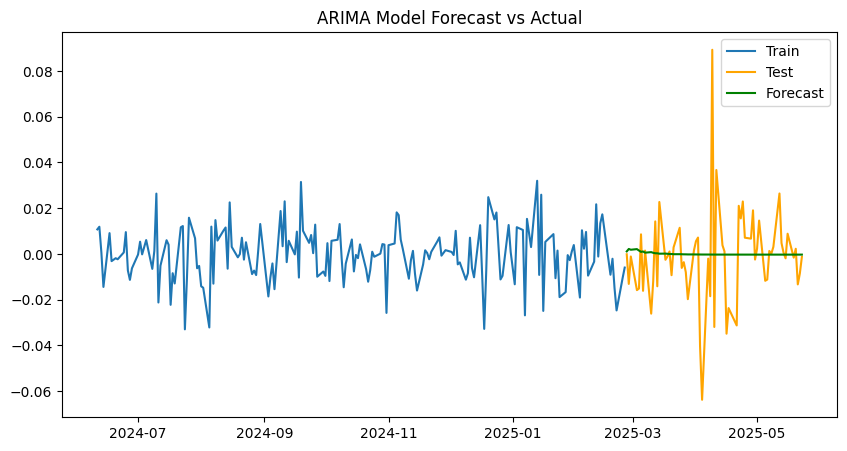

Test MAE: 0.01
Test RMSE: 0.02


In [38]:
# 5. Plot forecast vs actual
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

plt.figure(figsize=(10, 5))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color='orange')
plt.plot(test.index, forecast, label="Forecast", color='green')
plt.legend()
plt.title("ARIMA Model Forecast vs Actual")
plt.show()

# 6. Evaluate performance
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

In [35]:
ts =sp500_df["Closing_Price"]
train = ts[:177]
test = ts[177:]  

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[110] intercept   : AIC=inf, Time=20.74 sec
 ARIMA(0,0,0)(0,0,0)[110] intercept   : AIC=-1060.807, Time=0.18 sec
 ARIMA(1,0,0)(1,0,0)[110] intercept   : AIC=inf, Time=14.79 sec
 ARIMA(0,0,1)(0,0,1)[110] intercept   : AIC=inf, Time=17.26 sec
 ARIMA(0,0,0)(0,0,0)[110]             : AIC=-1062.631, Time=0.20 sec
 ARIMA(0,0,0)(1,0,0)[110] intercept   : AIC=inf, Time=13.23 sec
 ARIMA(0,0,0)(0,0,1)[110] intercept   : AIC=inf, Time=17.00 sec
 ARIMA(0,0,0)(1,0,1)[110] intercept   : AIC=inf, Time=5.85 sec
 ARIMA(1,0,0)(0,0,0)[110] intercept   : AIC=-1058.838, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[110] intercept   : AIC=-1058.832, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[110] intercept   : AIC=-1056.807, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[110]          
Total fit time: 90.407 seconds

Best SARIMA model order: (0, 0, 0) Seasonal Order: (0, 0, 0, 110)


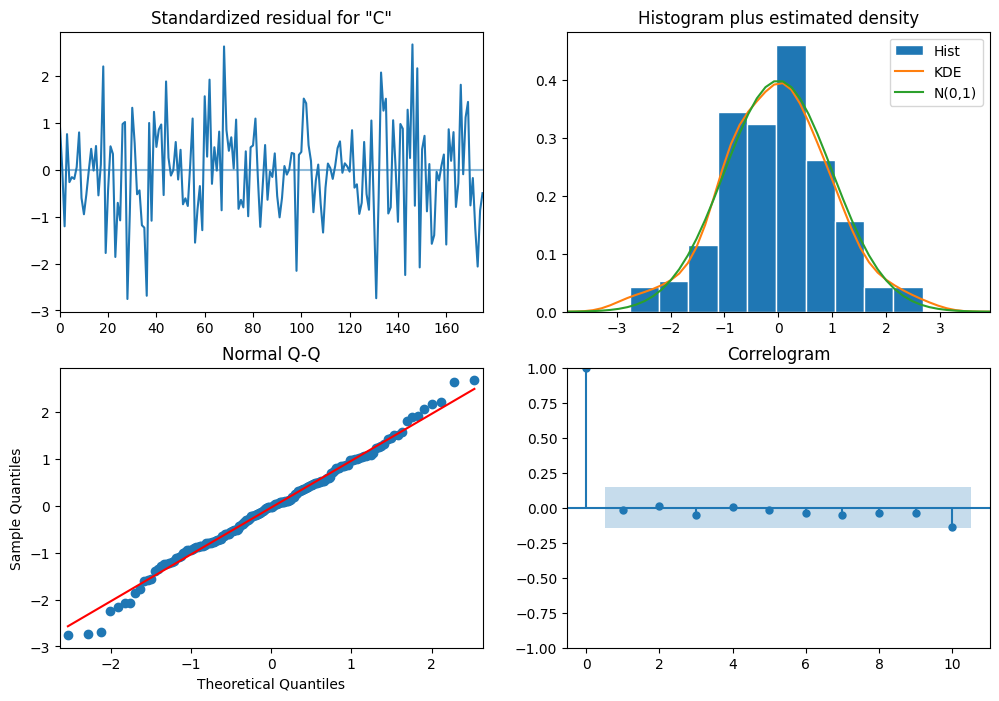

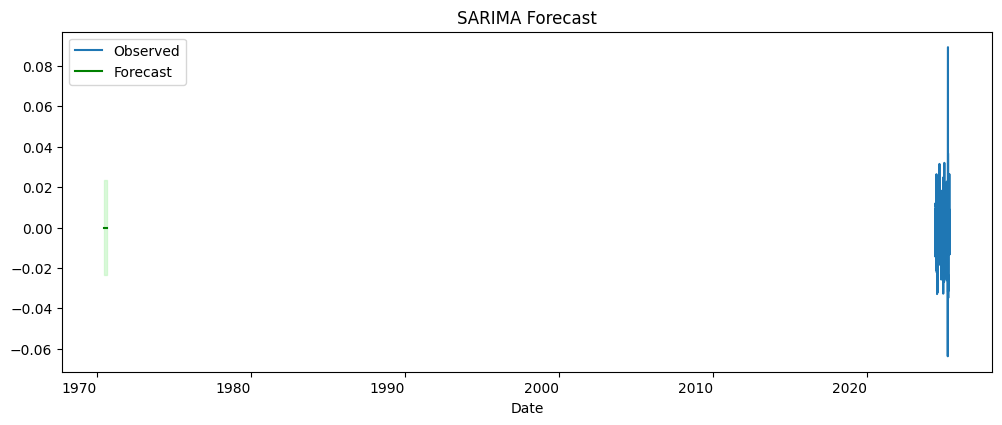

In [36]:


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")






stepwise_model = auto_arima(train,
                             seasonal=True, m=110, 
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)

print(f"\nBest SARIMA model order: {stepwise_model.order} Seasonal Order: {stepwise_model.seasonal_order}")


model = SARIMAX(train,
                order=stepwise_model.order,
                seasonal_order=stepwise_model.seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)

# Step 6: Model diagnostics
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Step 7: Forecast future values
n_forecast = len(test) 


forecast = results.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot the forecast
ax = ts.plot(label='Observed', figsize=(12, 5))
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='lightgreen', alpha=0.3)
plt.legend()
plt.title("SARIMA Forecast")          
plt.show()
